In [20]:
%matplotlib inline
import pandas as pd
data = pd.read_excel("ActualRatings_weeklyGRP.xls", sheet_name='TVRating_Data', index_col=0)
data.head()

,GRP
GRPRatingsDate,
17-Jun-2007 (25),243.60
24-Jun-2007 (26),263.19
01-Jul-2007 (27),269.89
08-Jul-2007 (28),252.88
15-Jul-2007 (29),303.46


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [22]:
data.index = data.index.str[:11]

In [23]:
data.index = pd.to_datetime(data.index)

In [24]:
import plotly

In [25]:
plotly.tools.set_credentials_file(username='81santi81', api_key='YrIPfoUSq1ESCQ99NVNh')

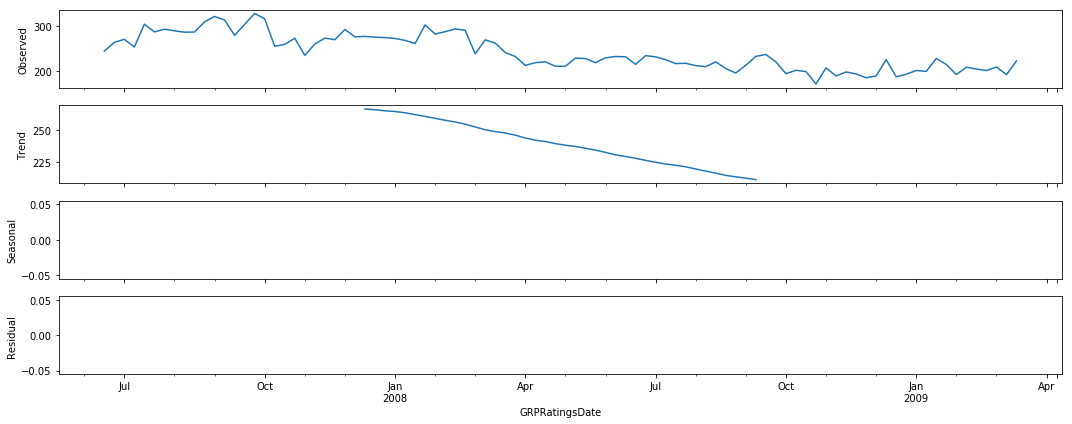

In [26]:
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative')
fig = result.plot()

In [27]:
data.head()

,GRP
GRPRatingsDate,
2007-06-17,243.60
2007-06-24,263.19
2007-07-01,269.89
2007-07-08,252.88
2007-07-15,303.46


In [28]:
ts = data['GRP'] 
ts.head(10)

GRPRatingsDate
2007-06-17    243.60
2007-06-24    263.19
2007-07-01    269.89
2007-07-08    252.88
2007-07-15    303.46
2007-07-22    286.29
2007-07-29    292.28
2007-08-05    288.72
2007-08-12    285.70
2007-08-19    286.01
Name: GRP, dtype: float64

In [29]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(2007,6,17)]

243.6

In [30]:
#2. Use ':' if one of the indices is at ends:
training = ts[:'2008-10-26']

In [31]:
test = ts['2008-11-02':]

In [32]:
test.size

20

In [33]:
training.size

72

In [34]:
import plotly.plotly as ply
import cufflinks as cf
training.iplot(title="TRP Ratings Jul 2007 to Sep 2008")

In [35]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Differrenced Values

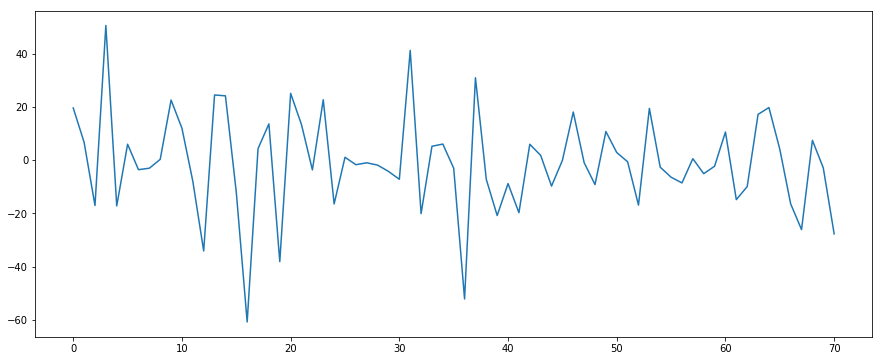

In [36]:
from matplotlib import pyplot
X = training.values
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

#### Decomposition
Here we can see there is an downward trend. We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.



We can use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every week we add 100 units of energy production). A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of energy production everyyear).

Based off the previous chart, it looks like the trend in these earlier days is slightly increasing at a higher rate than just linear (although it is a bit hard to tell from this one plot, we can always experiment with additive versus multiplicative methods.).

Again, Python and Statsmodels make this task incredibly easy in just a few lines of code:

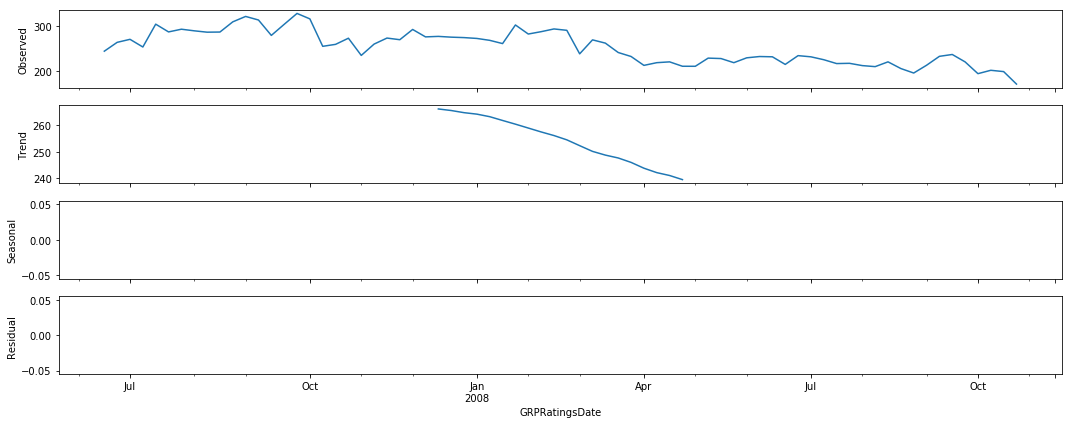

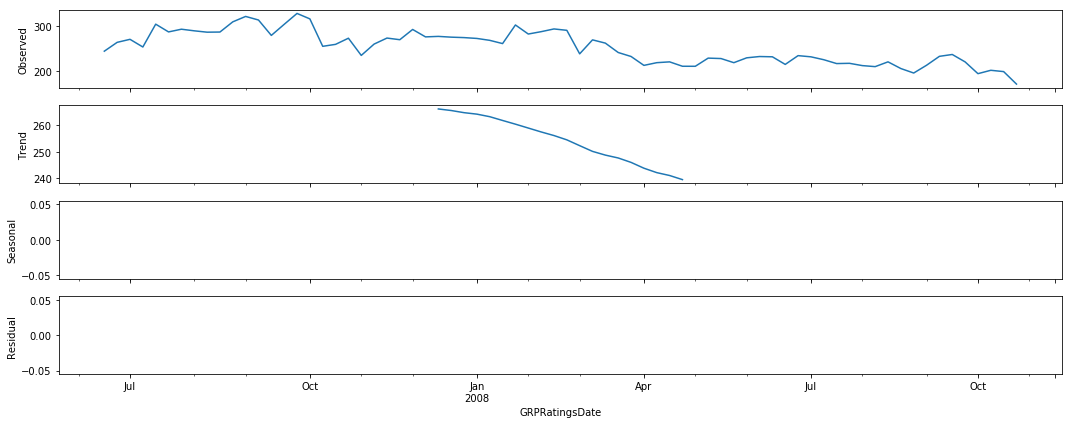

In [37]:
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(training, model='multiplicative')
fig = result.plot()
fig

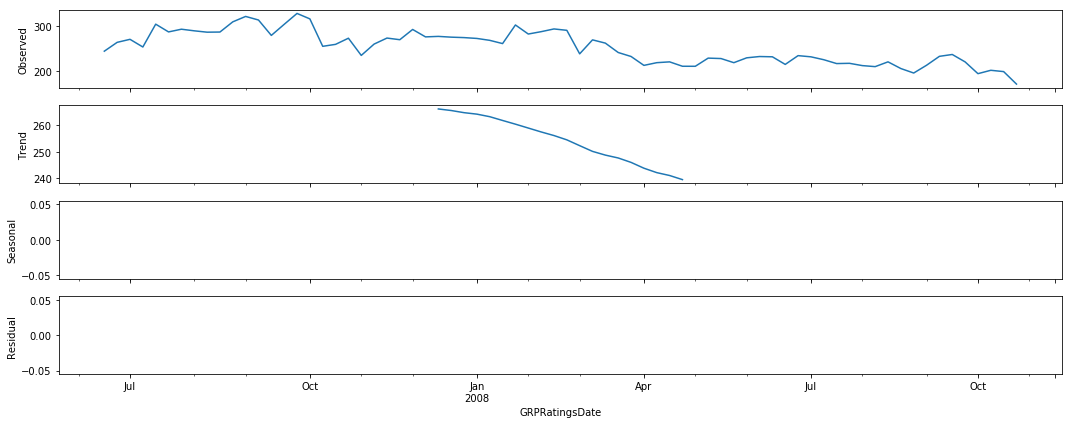

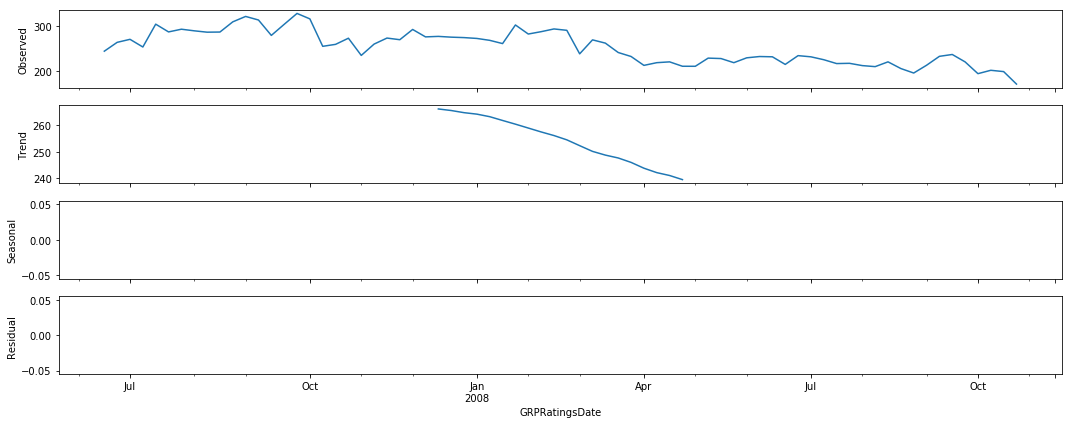

In [38]:
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(training, model='additive')
fig = result.plot()
fig

Performing the Seasonal ARIMA

There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data.

This library contains an auto_arima function that allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value.

In [54]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(training, start_q=0,
                            d=0,
                            p=3, max_q=3, m=7,
                           start_P=0, seasonal=False,
                            trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(2, 0, 0); AIC=629.991, BIC=639.098, Fit time=0.077 seconds
Fit ARIMA: order=(0, 0, 0); AIC=724.732, BIC=729.285, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=630.160, BIC=636.990, Fit time=0.034 seconds
Fit ARIMA: order=(0, 0, 1); AIC=677.161, BIC=683.991, Fit time=0.023 seconds
Fit ARIMA: order=(3, 0, 0); AIC=626.740, BIC=638.123, Fit time=0.084 seconds
Fit ARIMA: order=(3, 0, 1); AIC=628.732, BIC=642.392, Fit time=0.155 seconds
Fit ARIMA: order=(4, 0, 1); AIC=631.038, BIC=646.974, Fit time=0.714 seconds
Fit ARIMA: order=(4, 0, 0); AIC=628.726, BIC=642.386, Fit time=0.140 seconds
Total fit time: 1.230 seconds
626.73988707906


In [55]:
stepwise_model.fit(training)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [56]:
future_forecast = stepwise_model.predict(n_periods=20)

In [57]:
future_forecast

array([183.23276928, 191.28436294, 189.03674047, 190.79123156,
       194.19311717, 195.85537371, 197.4046218 , 199.34972025,
       201.0918423 , 202.66048125, 204.22229508, 205.72694956,
       207.14603475, 208.50630785, 209.81259615, 211.06006407,
       212.25263498, 213.39433833, 214.48652664, 215.53111928])

Let’s reorganize this set of predictions by creating a dataframe that contains our future forecast and then concatenating that with the original data.

We can then plot this to view how well our prediction forecast matched up with the test set for which we have the real data:


In [58]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).iplot()

In [59]:
future_forecast['Prediction'].values

array([183.23276928, 191.28436294, 189.03674047, 190.79123156,
       194.19311717, 195.85537371, 197.4046218 , 199.34972025,
       201.0918423 , 202.66048125, 204.22229508, 205.72694956,
       207.14603475, 208.50630785, 209.81259615, 211.06006407,
       212.25263498, 213.39433833, 214.48652664, 215.53111928])

In [60]:
mean_absolute_percentage_error(test.values,future_forecast['Prediction'].values)

5.125550336814144

In [61]:
# Fit a simple auto_arima model
arima = auto_arima(training, error_action='ignore', trace=1,
                      seasonal=False, m=12)

Fit ARIMA: order=(2, 1, 2); AIC=619.018, BIC=632.594, Fit time=0.114 seconds
Fit ARIMA: order=(0, 1, 0); AIC=621.776, BIC=626.302, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=620.114, BIC=626.902, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 1); AIC=616.933, BIC=623.721, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 1); AIC=616.870, BIC=625.921, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 2); AIC=618.110, BIC=629.423, Fit time=0.073 seconds
Fit ARIMA: order=(2, 1, 1); AIC=617.426, BIC=628.740, Fit time=0.048 seconds
Total fit time: 0.319 seconds


In [62]:
simpleArima_forecast = arima.predict(n_periods=test.shape[0])


In [63]:
simpleArima_forecast

array([180.35445455, 186.21613431, 189.60992531, 191.38079052,
       192.08439203, 192.08614271, 191.6263443 , 190.86302333,
       189.90010074, 188.80591672, 187.62541294, 186.38814381,
       185.11354482, 183.81439708, 182.49910566, 181.17319788,
       179.8403086 , 178.50282817, 177.16232852, 175.81984338])

In [64]:
mean_absolute_percentage_error(test.values,simpleArima_forecast)

8.367481512405476

#### StatsModel

In [69]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(training, order=(3, 0, 1)) 
model_fit = model.fit(disp=-1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [70]:
forecast = model_fit.forecast(steps=20)[0]

In [71]:
forecast

array([183.2664727 , 191.28609018, 188.90382202, 190.87167367,
       194.34806899, 195.95095093, 197.55264415, 199.55958079,
       201.31089516, 202.8988225 , 204.49152873, 206.0157102 ,
       207.45040786, 208.82811255, 210.14946609, 211.40928076,
       212.61318414, 213.76496527, 214.86567537, 215.91757254])

In [72]:
mean_absolute_percentage_error(test.values,forecast)

5.1841276017499105